In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
import warnings
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from matplotlib.patches import Ellipse
from sklearn.preprocessing import MinMaxScaler
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import davies_bouldin_score, silhouette_score

warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("../../data/GMM/shopping-data.csv", header=0, index_col=0)

data.head()

,Genre,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


In [3]:
X = data.iloc[:, 2:4].values

std = MinMaxScaler()
X_std = std.fit_transform(X)
print(X_std.shape)

(200, 2)


### EM

In [4]:
# Khởi tạo đối tượng mô hình GaussianMixture
gm = GaussianMixture(n_components=5,
covariance_type='full',
random_state=0)

gm.fit(X_std)
print('means: \n', gm.means_)
print('covariances: \n ', gm.covariances_)

means: 
 [[0.33368985 0.49394756]
 [0.60502531 0.15433196]
 [0.58393969 0.82673863]
 [0.09861098 0.21597752]
 [0.0829305  0.80743088]]
covariances: 
  [[[ 0.00613567 -0.00231927]
  [-0.00231927  0.0051635 ]]

 [[ 0.01818446  0.00433814]
  [ 0.00433814  0.00873064]]

 [[ 0.01808598 -0.00031096]
  [-0.00031096  0.0091568 ]]

 [[ 0.00453005  0.00255303]
  [ 0.00255303  0.01918353]]

 [[ 0.00337483 -0.0001437 ]
  [-0.0001437   0.01026088]]]


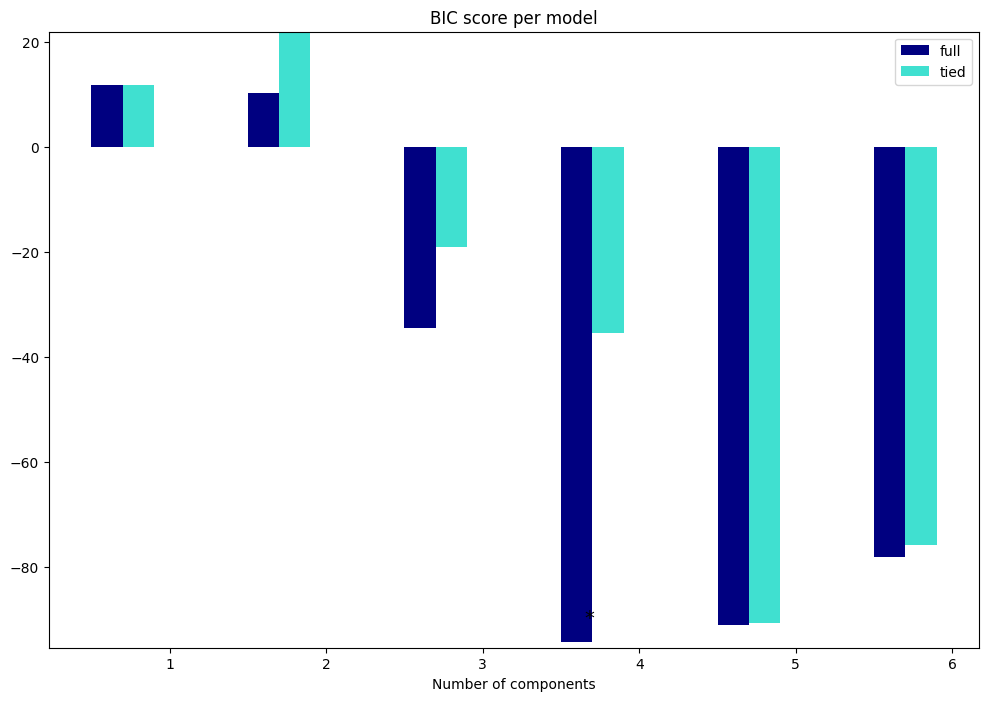

In [5]:
lowest_bic = np.inf
bic = []
n_components_range = range(1, 7)
# cv_types = ['spherical', 'tied', 'diag', 'full']
cv_types = ['full', 'tied']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit Gaussian mixture theo phương pháp huấn luyện EM
        gmm = GaussianMixture(n_components=n_components, covariance_type=cv_type)
        gmm.fit(X_std)
        bic.append(gmm.bic(X_std))
        # Gán model có BIC scores thấp nhất là model tốt nhất
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise'])
clf = best_gmm
bars = []

# Vẽ biểu đồ BIC scores
plt.figure(figsize=(12, 8))
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                    (i + 1) * len(n_components_range)], width=.2, color=color))

plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 + .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
plt.xlabel('Number of components')
plt.legend([b[0] for b in bars], cv_types)

In [6]:
def _plot_kmean_scatter(X, labels):
    '''
    X: dữ liệu đầu vào
    labels: nhãn dự báo
    '''
    # lựa chọn màu sắc
    num_classes = len(np.unique(labels))
    palette = np.array(sns.color_palette("hls", num_classes))
    
    # vẽ biểu đồ scatter
    fig = plt.figure(figsize=(12, 8))
    ax = plt.subplot()
    sc = ax.scatter(X[:,0], X[:,1], lw=0, s=40, c=palette[labels.astype(np.int64)])

    # thêm nhãn cho mỗi cluster
    txts = []
    
    for i in range(num_classes):
        # Vẽ text tên cụm tại trung vị của mỗi cụm
        xtext, ytext = np.median(X[labels == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
    plt.title('t-sne visualization')

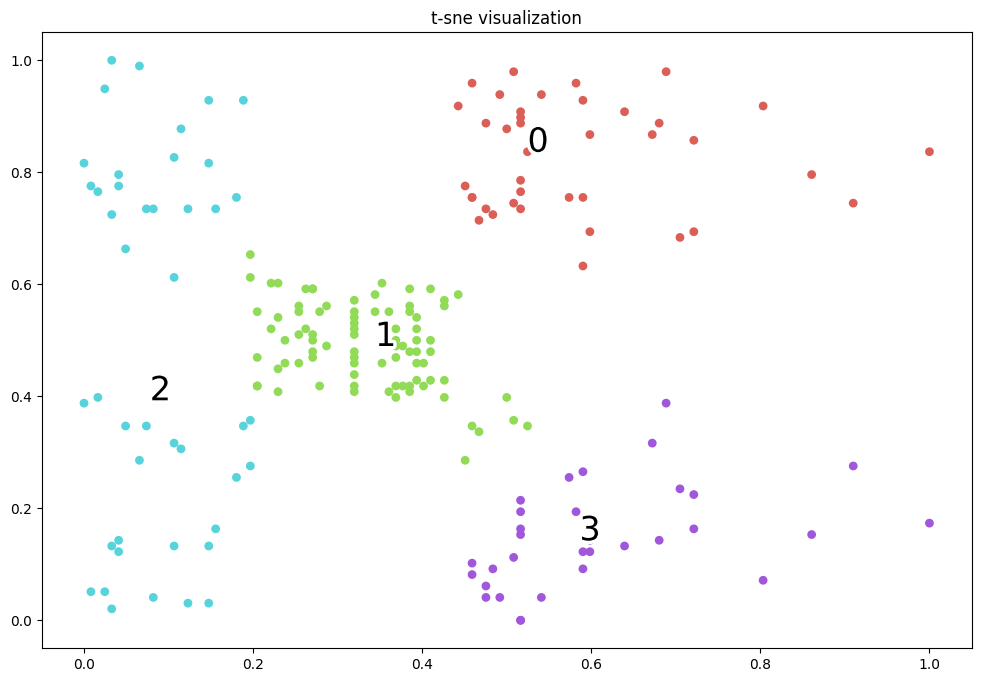

In [7]:
labels = best_gmm.predict(X_std)
_plot_kmean_scatter(X_std, labels)

In [8]:
print("Silhouette Score:", silhouette_score(X_std, labels))

Silhouette Score: 0.45666723532088693


In [9]:
print("Davies Bouldin Score:", davies_bouldin_score(X_std, labels))

Davies Bouldin Score: 1.190231033529174


### KMeans

In [10]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(X_std)

print('Centers found by scikit-learn:')
print(kmeans.cluster_centers_)

pred_label = kmeans.predict(X_std)

print(pred_label)

Centers found by scikit-learn:
[[0.33029751 0.49508692]
 [0.6        0.16443149]
 [0.58638083 0.82783883]
 [0.09265859 0.20319432]
 [0.08792846 0.79962894]]
[3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3
 4 3 4 3 4 3 0 3 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 2 1 2 0 2 1 2 1 2 0 2 1 2 1 2 1 2 1 2 0 2 1 2 1 2
 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1
 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2]


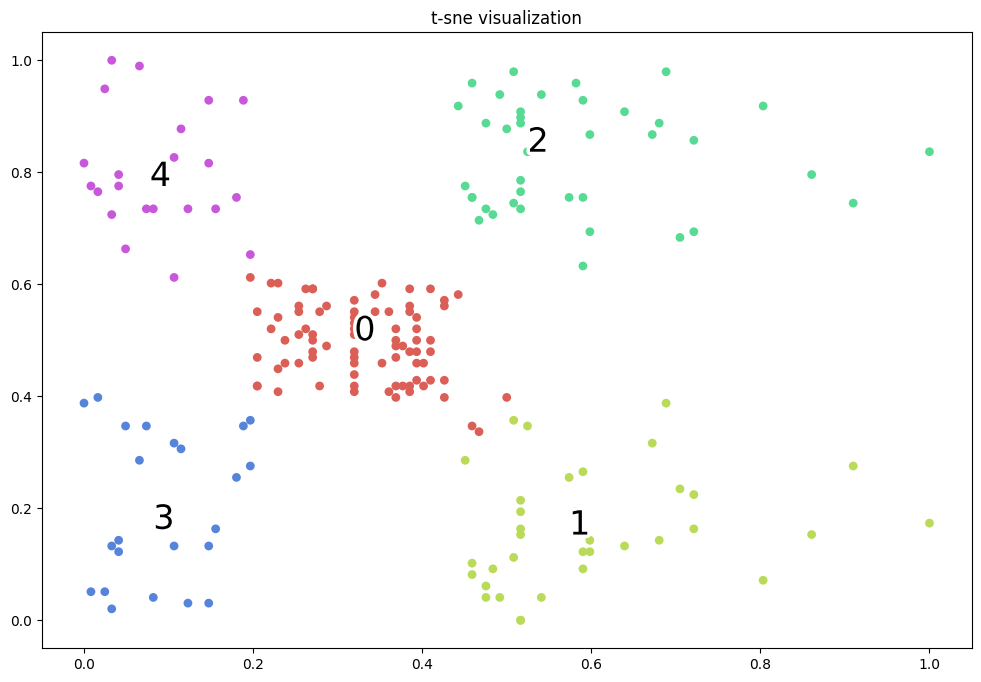

In [11]:
_plot_kmean_scatter(X_std, pred_label)

In [12]:
print("Silhouette Score:", silhouette_score(X_std, pred_label))

Silhouette Score: 0.5594854531227246


In [13]:
print("Davies Bouldin Score:", davies_bouldin_score(X_std, pred_label))

Davies Bouldin Score: 0.5678112087671997


### DBScan

In [14]:
dbscan = DBSCAN(eps=0.09, min_samples=4)
dbscan_labels = dbscan.fit_predict(X_std)

print(dbscan_labels)

[ 0  1  2  1  0  1  2 -1  2  1  2 -1  2  1  2  1  0  1  0 -1  0  1  2  1
  2  1  0  1  0  1  2  1  2  1  2  1  2  1  0  1  0  1  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  3  0  3  0  3  4  3  4  3  0  3  4  3  4  3  4  3  4  3  0  3
  4  3  0  3  4  3  4  3  4  3  4  3  4  3  4  3  0  3  4  3  4  3  4  3
  4  3  4  3  4  3  4  3  4  3  4  3  4  3  4  3 -1  3  4 -1  4  3  4 -1
 -1 -1 -1 -1 -1 -1 -1 -1]


In [15]:
print("Silhouette Score:", silhouette_score(X_std, dbscan_labels))

Silhouette Score: 0.47648030802443414


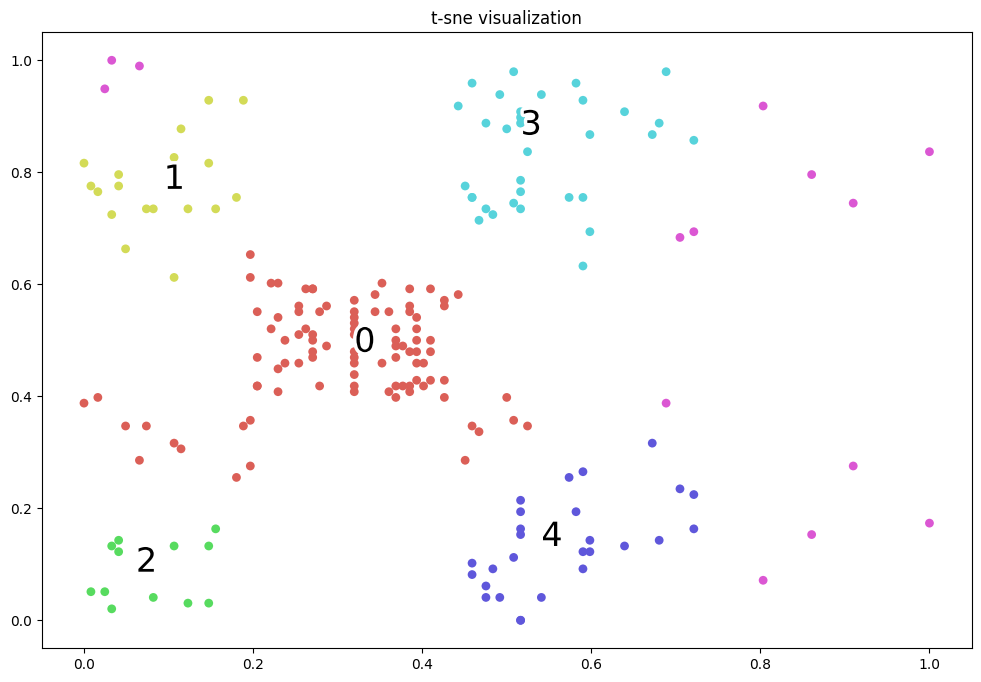

In [16]:
_plot_kmean_scatter(X_std, dbscan_labels)

**Nhận xét**:

* `KMeans` tốt nhất với (Silhouette Score 0.559), Davies-Bouldin 0.568, nhanh, ổn định, phù hợp cụm hình cầu.
* `EM (GMM)` hiệu quả (Silhouette Score 0.542), linh hoạt cho cụm Gaussian nhưng cần xử lý lỗi số học.
* `DBSCAN` kém nhất (Silhouette Score 0.476), có thể do tham số eps/minPts chưa tối ưu hoặc dữ liệu thiếu cấu trúc mật độ.

Khuyến nghị: Chọn KMeans nếu ưu tiên hiệu quả và đơn giản, GMM cho cụm phức tạp, tối ưu DBSCAN nếu dữ liệu có nhiễu rõ ràng.